In [158]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker 
import random
import numpy as np
import pandas as pd
import requests
import lxml.html as lh
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
url='https://extension2.missouri.edu/G403'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    '''if len(T)!=3:
        print("Length of T mismatch")
        break'''
#i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        #Check if row is empty
        #if i>0:
        #Convert any numerical value to integers
            #try:
             #   data=int(data)
            #except:
             #   None
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

#Convert List of tuples (with lists) into a dict and then into a dataframe
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [169]:
df.rename(columns={'1997b':'1997'},inplace=True)
variables_list=df.columns[1:]
variables_list

Index(['1959', '1964', '1969', '1974', '1978', '1982', '1987', '1992', '1997',
       '2002', '2007', '2012', '2017'],
      dtype='object')

In [171]:
for v in variables_list:
    df[v].replace(to_replace='[^0-9]+', value='',inplace=True,regex=True)
    df=df.astype({v:'int64'})

In [172]:
dfWide=df
dfWide=pd.melt(dfWide,id_vars=['County'],value_vars=variables_list, var_name='Year',value_name='AcrePrice')
dfWide=dfWide.sort_values(by=['County','Year'])
dfWide['Pct_Chg']=dfWide.groupby('County')['AcrePrice'].apply(lambda x: (x-x.shift(1))/x)
dfWide.head(10)

,County,Year,AcrePrice,Pct_Chg
0,Adair,1959,115,NaN
115,Adair,1964,118,0.025424
230,Adair,1969,168,0.297619
345,Adair,1974,299,0.438127
460,Adair,1978,511,0.414873
575,Adair,1982,635,0.195276
690,Adair,1987,418,-0.519139
805,Adair,1992,454,0.079295
920,Adair,1997,650,0.301538
1035,Adair,2002,1012,0.357708


In [190]:
url='https://mcdc.missouri.edu/geography/reference/MO_Region_Codes.html'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')[14:]
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    '''if len(T)!=3:
        print("Length of T mismatch")
        break'''
#i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        #Check if row is empty
        #if i>0:
        #Convert any numerical value to integers
            #try:
             #   data=int(data)
            #except:
             #   None
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

#Convert List of tuples (with lists) into a dict and then into a dataframe
Dict={title:column for (title,column) in col}
df2=pd.DataFrame(Dict)

In [232]:
dfWide2=pd.merge(dfWide,df2, left_on='County', right_on='county', how='left')
dfWide2.drop(columns='county',inplace=True)

In [233]:
dfWide2['Region']=np.where(pd.isnull(dfWide2['Region']),'Avg',dfWide2['Region'])
dfWide2

,County,Year,AcrePrice,Pct_Chg,Fipco,Region
0,Adair,1959,115,NaN,29001,Northeast
1,Adair,1964,118,0.025424,29001,Northeast
2,Adair,1969,168,0.297619,29001,Northeast
3,Adair,1974,299,0.438127,29001,Northeast
4,Adair,1978,511,0.414873,29001,Northeast
...,...,...,...,...,...,...
1490,Wright,1997,881,0.257662,29229,South Central
1491,Wright,2002,1259,0.300238,29229,South Central
1492,Wright,2007,1811,0.304804,29229,South Central
1493,Wright,2012,1797,-0.007791,29229,South Central


In [237]:
dfWide2['Region'].unique()

array(['Northeast', 'Northwest', 'Central', 'Southwest', 'West Central',
       'Lower East Central-Cape', 'Bootheel', 'Lake Ozark Rolla',
       'North Central', 'Kansas City MSA', 'Springfield - Branson',
       'South Central', 'St. Louis MSA', 'Avg'], dtype=object)

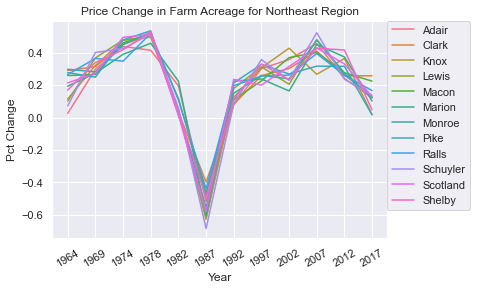

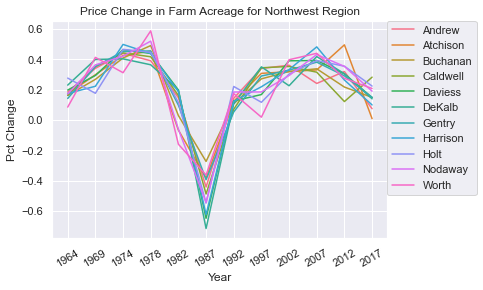

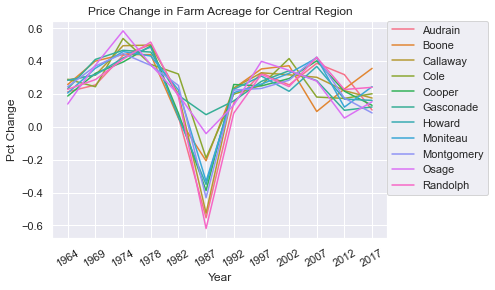

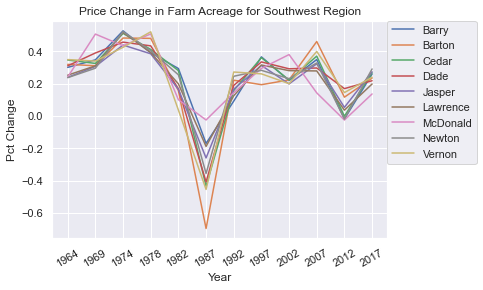

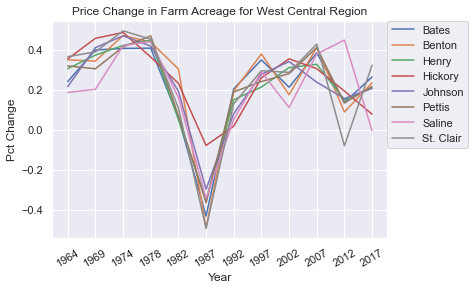

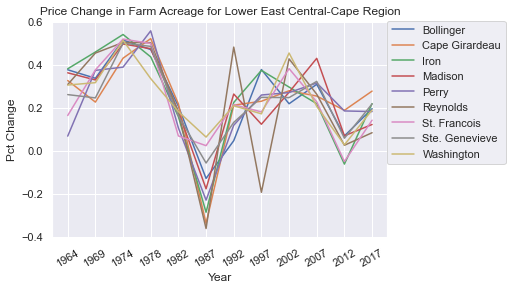

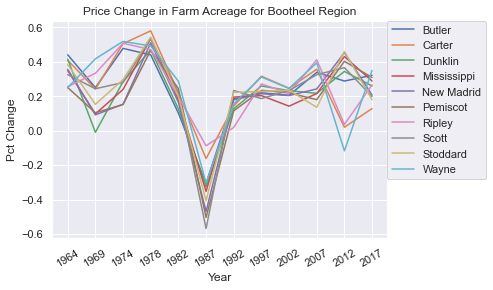

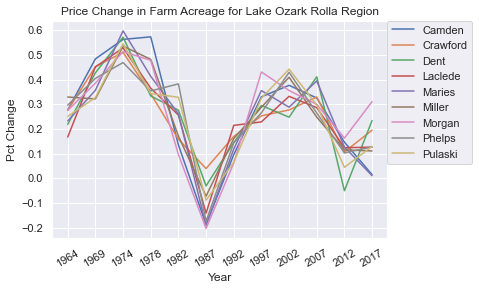

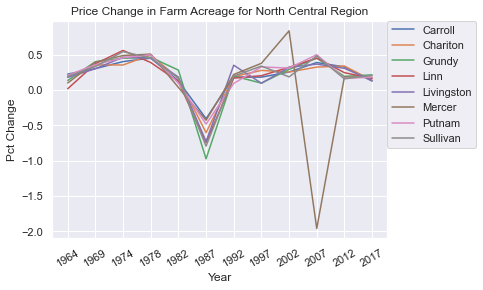

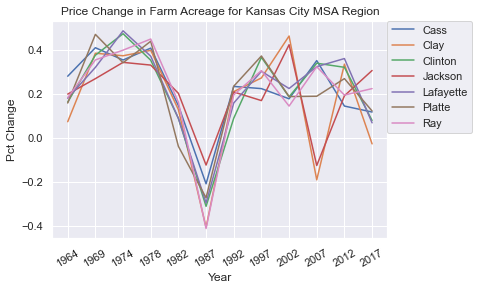

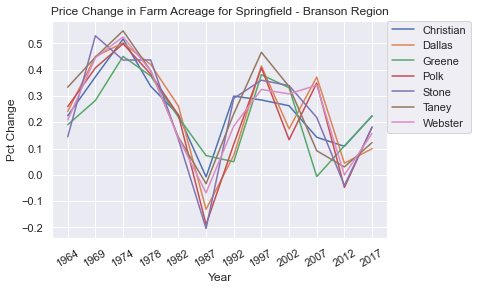

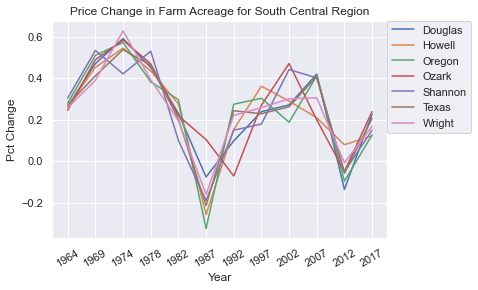

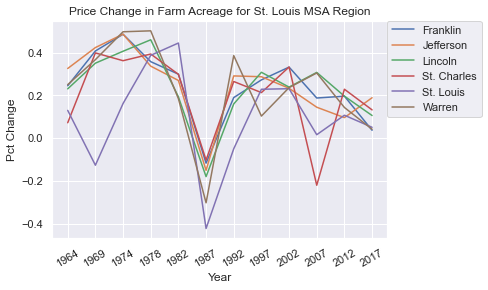

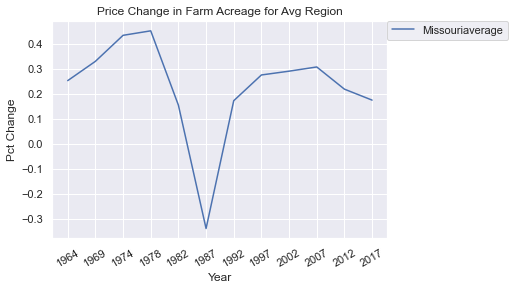

In [257]:

for v in dfWide2['Region'].unique():
    dfPlot=dfWide2[dfWide2.Region==v]
    sns.set_theme(style="darkgrid")
    g=sns.lineplot(x = "Year", y = "Pct_Chg", hue="County", data = dfPlot)
    g.set_xticklabels(labels=dfPlot.Year.unique(),rotation=30)
    g.set_ylabel('Pct Change')
    g.set(title='Price Change in Farm Acreage for {} Region'.format(v))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [246]:
help(g.)

Help on method set_ylabel in module matplotlib.axes._axes:

set_ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the label for the y-axis.
    
    Parameters
    ----------
    ylabel : str
        The label text.
    
    labelpad : float, default: None
        Spacing in points from the axes bounding box including ticks
        and tick labels.
    
    loc : {'bottom', 'center', 'top'}, default: :rc:`yaxis.labellocation`
        The label position. This is a high-level alternative for passing
        parameters *y* and *horizontalalignment*.
    
    Other Parameters
    ----------------
    **kwargs : `.Text` properties
        `.Text` properties control the appearance of the label.
    
    See Also
    --------
    text : Documents the properties supported by `.Text`.

